In [2]:
import numpy as np
import faiss
from time import time
import matplotlib.pyplot as plt
from collections import defaultdict

## Helper Function

In [3]:
def semi_optimized_exhaustive_search(
        index_vectors: np.ndarray,
        query_vectors: np.ndarray,
        k: int,
):
    """
    This function performs an optimized exhaustive search.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        dim: The dimensionality of the vectors.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k nearest neighbors for each query vector.
    """
    ann_lists = []
    for query_vec in query_vectors:
        distances = np.linalg.norm(index_vectors - query_vec, axis=1)
        ann_lists.append(list(np.argsort(distances)[:k]))
    return np.array(ann_lists)

In [4]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [5]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (, ) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [6]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [7]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 2.1 -- LSH vs Naive Exhaustive Search (Regular Index Vectors)
### You just have to run the following cells and add the following results to the report:
* running time of the ground truth computation with semi_optimized_exhaustive_search (wall time)
* running time of creating faiss_lsh_index (wall time)
* running time of faiss_search over query_vectors with faiss_lsh_index (wall time)
* recall@10 for faiss_lsh_ann

In [90]:
query_vectors = np.load('data/query_vectors.npy')
index_vectors = np.load('data/index_vectors.npy')
k=10
dim = index_vectors.shape[1]

In [9]:
query_vectors2 = np.load('data/query_vectors2.npy')
index_vectors2 = np.load('data/index_vectors2.npy')

query_vectors3 = np.load('data/query_vectors3.npy')
index_vectors3 = np.load('data/index_vectors3.npy')

In [91]:
%%time
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)

CPU times: total: 18.9 s
Wall time: 24.6 s


In [92]:
%%time
gt_nn2 = semi_optimized_exhaustive_search(index_vectors2, query_vectors2, k)

CPU times: total: 38.4 s
Wall time: 47.5 s


In [93]:
%%time
gt_nn3 = semi_optimized_exhaustive_search(index_vectors3, query_vectors3, k)

CPU times: total: 20 s
Wall time: 23.7 s


In [94]:
%%time
faiss_lsh_index = build_faiss_lsh_index(index_vectors, dim, nbits=2000)

CPU times: total: 3.03 s
Wall time: 902 ms


In [95]:
%%time
faiss_lsh_ann = faiss_search(query_vectors, faiss_lsh_index, k)

CPU times: total: 812 ms
Wall time: 172 ms


In [96]:
print(f"recall@10 for faiss_lsh_index: {compute_recall_at_k(gt_nn, faiss_lsh_ann, k)}")

recall@10 for faiss_lsh_index: 0.167


# 2.2 -- Custom Indexing Algorithm
Build an indexing algorithm that satisfies the following requirements:
* The indexing algorithm should be able to handle vectors of different dimensions
* The running time of the indexing should be less than half of the running time of semi_optimized_exhaustive_search), reported in Section 2.1.
* The running time of searching over the index should be less than a third (1/3) of the time of the semi_optimized_exhaustive_search function, reported in Section 2.1.
* The performance (in terms of recall@10) of the indexing algorithm should be at least 0.8.

The last three bullets should also appear in the report.
You are allowed to add as many helper functions as you need. You cannot use faiss of scipy libraries for this task. Numpy is allowed. 

You can also test your algorithm with the additional two query-index sets by replacing the calls made few cells ago to:

    query_vectors = np.load('data/query_vectors2.npy')
    index_vectors = np.load('data/index_vectors2.npy')
or:

    query_vectors = np.load('data/query_vectors3.npy')
    index_vectors = np.load('data/index_vectors3.npy')
    
the aforementioned requirements should also be satisfied over these two query-index sets. No need to insert the results over these two to the report.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
import heapq

class PCA_Kmeans:
    def __init__(self, min_clusters=7, max_clusters=15):
        self.min_clusters = min_clusters
        self.max_clusters = max_clusters
        self.kmeans = None
        self.reduced_data = None
        self.original_data = None
        self.pca = None
        self.cluster_labels = None
        self.cluster_map = defaultdict(list)
        self.cluster_centers = None

    def fit(self, data):
        self.original_data = np.array(data)
        self._perform_pca()
        self._find_optimal_clusters_and_kmeans()

    def _perform_pca(self):
        self.pca = PCA(n_components=2)
        self.reduced_data = self.pca.fit_transform(self.original_data)

    def _find_optimal_clusters_and_kmeans(self):
        sse, kmeans_models = self._calculate_sse_and_models()
        elbow = self._find_elbow(sse)
        self.kmeans = kmeans_models[elbow - self.min_clusters]
        self._assign_clusters()

    def _calculate_sse_and_models(self):
        sse, kmeans_models = [], []
        for k in range(self.min_clusters, self.max_clusters + 1):
            kmeans = KMeans(n_clusters=k).fit(self.reduced_data)
            sse.append(kmeans.inertia_)
            kmeans_models.append(kmeans)
        return sse, kmeans_models

    def _find_elbow(self, sse):
        diff2 = np.diff(np.diff(sse))
        return np.argmax(diff2) + self.min_clusters + 1

    def _assign_clusters(self):
        self.cluster_centers = self.kmeans.cluster_centers_
        cluster_labels = self.kmeans.labels_
        for idx, label in enumerate(cluster_labels):
            self.cluster_map[label].append(idx)

    def _euclidean_distance(self, v1, v2):
        return np.linalg.norm(v1 - v2)
    
    def query(self, query_vector, k):
        reduced_query = self.pca.transform([query_vector])[0]
        nearest_cluster_idx = self._find_nearest_cluster_idx(reduced_query)
        candidate_indices = self.cluster_map[nearest_cluster_idx]
        return self._get_k_nearest_neighbors(query_vector, candidate_indices, k)

    def _find_nearest_cluster_idx(self, reduced_query):
        distances = np.linalg.norm(self.cluster_centers - reduced_query, axis=1)
        return np.argmin(distances)

    def _get_k_nearest_neighbors(self, query_vector, candidate_indices, k):
        distances = np.linalg.norm(self.original_data[candidate_indices] - query_vector, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return [candidate_indices[i] for i in nearest_indices]

    def queries(self, query_vectors, k):
        return [self.query(query_vector, k) for query_vector in query_vectors]
    
    def plot_clusters(self):
        plt.figure(figsize=(10, 8))
        for label, indices in self.cluster_map.items():
            cluster_data = self.reduced_data[indices]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {label} (Size: {len(indices)})')
        plt.title('Clusters after PCA and K-Means')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True)
        plt.show()

    def print_cluster_sizes(self):
        for label, indices in self.cluster_map.items():
            print(f'Cluster {label}: Size {len(indices)}')



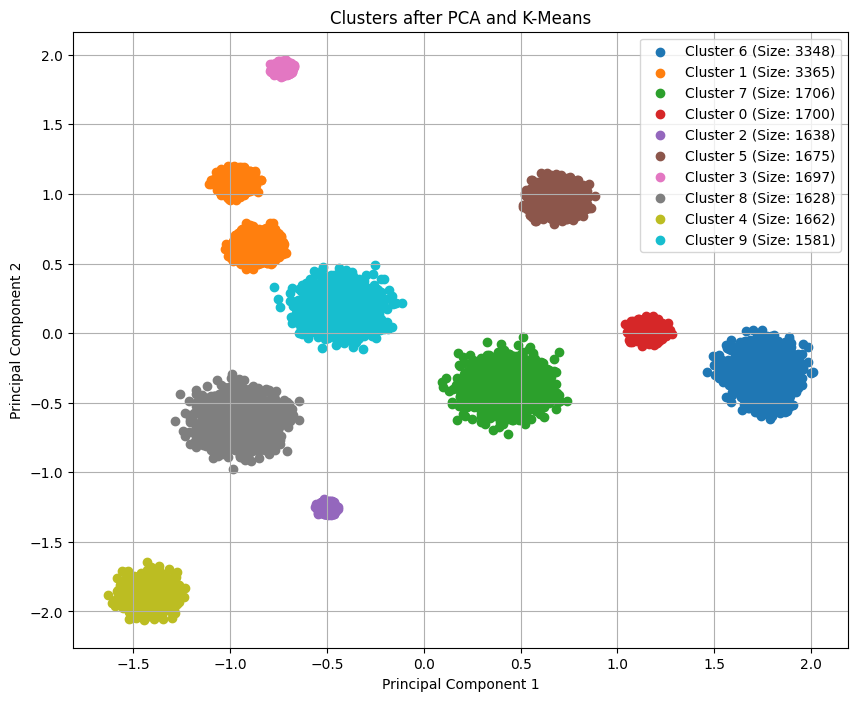

In [85]:
idx.plot_clusters()

In [98]:
%%time
idx = PCA_Kmeans()
idx.fit(index_vectors3)

CPU times: total: 656 ms
Wall time: 210 ms


In [83]:
%%time
gt_nn_pca = idx.queries(query_vectors3, k)

CPU times: total: 2.16 s
Wall time: 2.41 s


In [84]:
print(f"recall@10 for custom_index_search: {compute_recall_at_k(gt_nn3, gt_nn_pca, k)}")

recall@10 for custom_index_search: 1.0


In [86]:
#TODO: Write your code for 2.2.2 here
# You are allowed to add more arguments to the functions and create more functions if needed.
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

class PCA_Kmeans:
    def __init__(self, min_clusters=7, max_clusters=15):
        # Initialize the PCA_Kmeans class with the min_clusters and max_clusters
        """
        This function initializes the PCA_Kmeans class.
        Args:
            min_clusters: The minimum number of clusters to consider.
            max_clusters: The maximum number of clusters to consider.            
        """
        self.min_clusters = min_clusters
        self.max_clusters = max_clusters
        self.kmeans = None
        self.reduced_vectors = None
        self.original_vectors = None
        self.pca = None
        self.cluster_map = defaultdict(list)
        self.cluster_centers = None

    def fit(self, index_vectors):
        """
        This function fits the PCA and KMeans models to the index vectors.
        Args:
            index_vectors: An array of shape (n_index, dim) containing the index vectors.
        """
        self.original_vectors = np.array(index_vectors)
        self._perform_pca()
        self._find_optimal_clusters_and_kmeans()

    def _perform_pca(self):
        """
        This function performs PCA on the original vectors.
        """
        self.pca = PCA(n_components=2)
        self.reduced_data = self.pca.fit_transform(self.original_data)

    def _find_optimal_clusters_and_kmeans(self):
        """
        This function finds the optimal number of clusters and fits the KMeans model.
        """
        sse, kmeans_models = self._calculate_sse_and_models()
        elbow = self._find_elbow(sse)
        self.kmeans = kmeans_models[elbow - self.min_clusters]
        self._assign_clusters()

    def _calculate_sse_and_models(self):
        """
        This function calculates the sum of squared errors for different numbers of clusters.
        Returns:
            sse: A list containing the sum of squared errors for different numbers of clusters.
            kmeans_models: A list containing the KMeans models for different numbers of clusters.
        """
        sse, kmeans_models = [], []
        for k in range(self.min_clusters, self.max_clusters + 1):
            kmeans = KMeans(n_clusters=k).fit(self.reduced_data)
            sse.append(kmeans.inertia_)
            kmeans_models.append(kmeans)
        return sse, kmeans_models

    def _find_elbow(self, sse):
        """
        This function finds the elbow point in the SSE curve.
        Args:
            sse: A list containing the sum of squared errors for different numbers of clusters.
        Returns:
            The optimal number of clusters.
        """
        diff2 = np.diff(np.diff(sse))
        return np.argmax(diff2) + self.min_clusters + 1

    def _assign_clusters(self):
        """
        This function assigns the vectors to clusters.
        """
        self.cluster_centers = self.kmeans.cluster_centers_
        cluster_labels = self.kmeans.labels_
        for idx, label in enumerate(cluster_labels):
            self.cluster_map[label].append(idx)
    
    def query(self, query_vector, k):
        """
        This function finds the k-nearest neighbors for a query vector.
        Args:
            query_vector: The query vector.
            k: The number of nearest neighbors to retrieve.
        Returns:
            A list containing the indices of the k-nearest neighbors.
        """
        reduced_query = self.pca.transform([query_vector])[0]
        nearest_cluster_idx = self._find_nearest_cluster_idx(reduced_query)
        candidate_indices = self.cluster_map[nearest_cluster_idx]
        return self._get_k_nearest_neighbors(query_vector, candidate_indices, k)

    def _find_nearest_cluster_idx(self, reduced_query):
        """
        This function finds the nearest cluster to a query vector.
        Args:
            reduced_query: The reduced query vector.
        Returns:
            The index of the nearest cluster.
        """
        distances = np.linalg.norm(self.cluster_centers - reduced_query, axis=1)
        return np.argmin(distances)

    def _get_k_nearest_neighbors(self, query_vector, candidate_indices, k):
        """
        This function finds the k-nearest neighbors from a list of candidate indices.
        Args:
            query_vector: The query vector.
            candidate_indices: A list of candidate indices.
            k: The number of nearest neighbors to retrieve.
        Returns:
            A list containing the indices of the k-nearest neighbors.
        """
        distances = np.linalg.norm(self.original_data[candidate_indices] - query_vector, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return [candidate_indices[i] for i in nearest_indices]

    def queries(self, query_vectors, k):
        """
        This function finds the k-nearest neighbors for multiple query vectors.
        Args:
            query_vectors: An array of shape (n_queries, dim) containing the query vectors.
            k: The number of nearest neighbors to retrieve.
        Returns:
            A list of lists containing the indices of the k-nearest neighbors for each query vector.
        """
        return [self.query(query_vector, k) for query_vector in query_vectors]
            

def custom_indexing_algorithm(index_vectors, dim):
    """
    This function builds an index from scratch.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
    Returns:
        An index.
    """
    idx = PCA_Kmeans()
    idx.fit(index_vectors)
    return idx


def custom_index_search(query_vectors, index, k):
    """
    This function searches over the custom index.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index: The custom index.
        k: The number of nearest neighbors to retrieve.
    """
    gt_nn_pca = index.queries(query_vectors, k)
    return gt_nn_pca
    

In [ ]:
# Add hyperparameters here (if needed)

In [99]:
%%time
custom_index = custom_indexing_algorithm(index_vectors, dim)

CPU times: total: 219 ms
Wall time: 194 ms


In [100]:
%%time
custom_index_ann = custom_index_search(query_vectors, custom_index, k)

CPU times: total: 3.27 s
Wall time: 5.2 s


In [101]:
print(f"recall@10 for custom_index_search: {compute_recall_at_k(gt_nn, custom_index_ann, k)}")

recall@10 for custom_index_search: 1.0


In [ ]:
for k in [3, 5, 10, 15, 20, 50, 100]:
    t = time()
    gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)
    print(f"Third of time for semi_optimized_exhaustive_search with k={k}: {round((time()-t)/3, 2)}")
    pca_index = PCA_Kmeans()
    pca_index.fit(index_vectors)
    t = time()
    gt_nn_pca = pca_index.queries(query_vectors, k)
    print(f"Time for custom_index_search with k={k}: {round(time()-t, 2)},    recall@{k}: {compute_recall_at_k(gt_nn, gt_nn_pca, k)}\n")

Size of cluster 1: 2571
Size of cluster 2: 2457
Size of cluster 3: 2534
Size of cluster 4: 2495
Size of cluster 5: 2534
Size of cluster 6: 2420
Size of cluster 7: 2495
Size of cluster 8: 2494


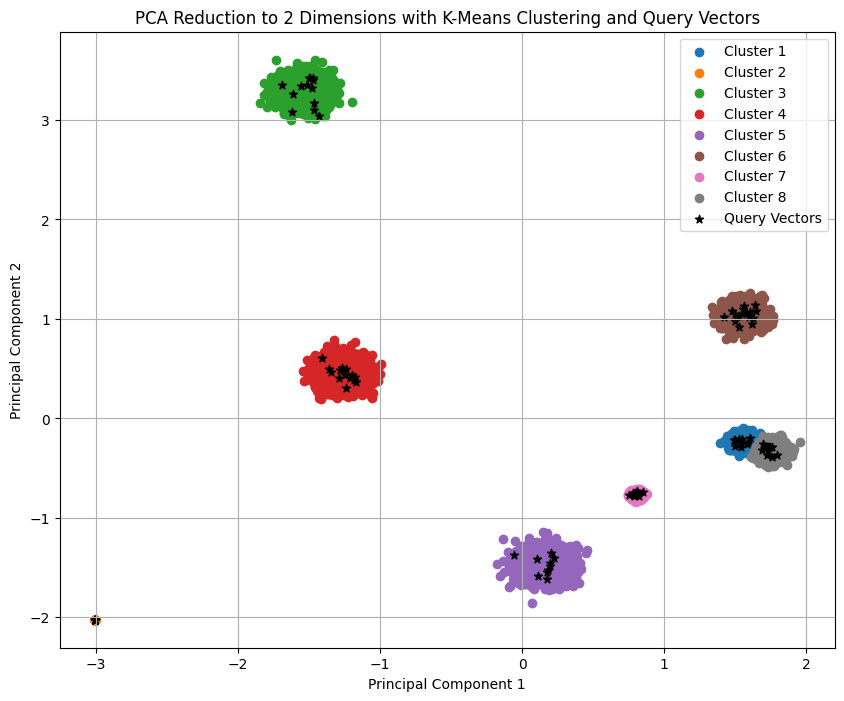

In [109]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming index_vectors and query_vectors are already defined
# index_vectors = np.random.rand(100, 20)  # Replace this with your actual data
# query_vectors = np.random.rand(10, 20)   # Replace this with your actual query data

# Perform PCA to reduce to 2 dimensions on the index vectors
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(index_vectors2)

# Transform the query vectors to the same PCA-reduced space
reduced_query_vectors = pca.transform(query_vectors2[:100])

# Perform K-Means clustering on the index vectors
num_clusters = 8  # Adjust this to the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(reduced_vectors)

# Print the size of each cluster
for cluster_id in range(num_clusters):
    cluster_size = np.sum(cluster_labels == cluster_id)
    print(f"Size of cluster {cluster_id + 1}: {cluster_size}")

# Plot the reduced index vectors with cluster coloring
plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_points = reduced_vectors[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id + 1}')

# Plot the reduced query vectors in a different color
plt.scatter(reduced_query_vectors[:, 0], reduced_query_vectors[:, 1], c='black', marker='*', label='Query Vectors')

plt.title('PCA Reduction to 2 Dimensions with K-Means Clustering and Query Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()